Collapsed Gibbs Sampling for Bayesian Mixture Models (with a Nonparametric Extension)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple, Counter
from scipy import stats
from numpy import random

In [2]:
np.random.seed(12345)

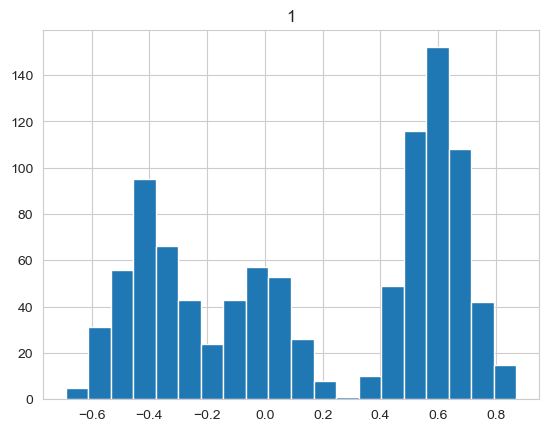

In [3]:
data = pd.read_csv("clusters.csv", header=None)
second_column = data.iloc[:, 1]
data = pd.DataFrame(second_column)
data_array = second_column.values
# data = data.drop('0', axis=1)
_=data.hist(bins=20)

In [70]:
SuffStat = namedtuple('SuffStat', 'theta N')

def update_suffstats(state):
    for cluster_id, N in Counter(state['assignment']).items():
        points_in_cluster = []
        for x, cid in zip(data_array, state['assignment']):
            if cid == cluster_id:
                points_in_cluster.append(x)
        mean = np.array(points_in_cluster).mean()
        state['suffstats'][cluster_id] = SuffStat(mean, N)

def initial_state(num_clusters=3, alpha=1.0):
    cluster_ids = list(range(num_clusters))

    state = {
        'cluster_ids_': cluster_ids,
        'data_': data_array,
        'num_clusters_': num_clusters,
        'cluster_variance_': .01,
        'alpha_': alpha,
        'hyperparameters_': {
            "mean": 0,
            "variance": 1,
        },
        'suffstats': {cid: None for cid in cluster_ids},
        'assignment': [random.choice(cluster_ids) for _ in data.T],
        'pi': [alpha / num_clusters for _ in cluster_ids],
        'cluster_means': [-1, 0, 1]
    }
    update_suffstats(state)
    return state

state = initial_state()

In [14]:
def log_predictive_likelihood(data_id, cluster_id, state):
    """Predictive likelihood of the data at data_id is generated
    by cluster_id given the current state.

    From Section 2.4 of
    http://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
    """
    ss = state['suffstats'][cluster_id]
    hp_mean = state['hyperparameters_']['mean']
    hp_var = state['hyperparameters_']['variance']
    param_var = state['cluster_variance_']
    x = state['data_'][data_id]
    return _log_predictive_likelihood(ss, hp_mean, hp_var, param_var, x)


def _log_predictive_likelihood(ss, hp_mean, hp_var, param_var, x):
    posterior_sigma2 = 1 / (ss.N * 1. / param_var + 1. / hp_var)
    predictive_mu = posterior_sigma2 * (hp_mean * 1. / hp_var + ss.N * ss.theta * 1. / param_var)
    predictive_sigma2 = param_var + posterior_sigma2
    predictive_sd = np.sqrt(predictive_sigma2)
    return stats.norm(predictive_mu, predictive_sd).logpdf(x)


def log_cluster_assign_score(cluster_id, state):
    """Log-likelihood that a new point generated will
    be assigned to cluster_id given the current state.
    """
    current_cluster_size = state['suffstats'][cluster_id].N
    num_clusters = state['num_clusters_']
    alpha = state['alpha_']
    return np.log(current_cluster_size + alpha * 1. / num_clusters)

In [27]:
# To simplify the computation of things like
#  (where we remove point
#  from the summary statistics), we create two simple functions to add and remove a point from the summary statistics for a given cluster.

def cluster_assignment_distribution(data_id, state):
    """Compute the marginal distribution of cluster assignment
    for each cluster.
    """
    scores = {}
    for cid in state['cluster_ids_']:
        scores[cid] = log_predictive_likelihood(data_id, cid, state)
        scores[cid] += log_cluster_assign_score(cid, state)

    # scores = {cid: np.exp(score) for cid, score in scores.iteritems()}
    # normalization = 1.0/sum(scores.values())
    # scores = {cid: score*normalization for cid, score in scores.iteritems()}
    for key in scores:
        scores[key] = np.exp(scores[key])
    normalization = 1.0/sum(scores.values())
    for key in scores:
        scores[key] = scores[key] * normalization

    return scores

def add_datapoint_to_suffstats(x, ss):
    """Add datapoint to sufficient stats for normal component
    """
    return SuffStat((ss.theta*(ss.N)+x)/(ss.N+1), ss.N+1)


def remove_datapoint_from_suffstats(x, ss):
    """Remove datapoint from sufficient stats for normal component
    """
    return SuffStat((ss.theta*(ss.N)-x*1.0)/(ss.N-1), ss.N-1)


In [16]:
# Finally, we're ready to create a function that takes a Gibbs step on the state. For each datapoint, it
#
# Removes the datapoint from its current cluster.
# Computes the posterior probability of the point being assigned to each cluster (given the other current assignments).
# Assigns the datapoint to a cluster sampled from this probability distribution.

def gibbs_step(state):
    pairs = zip(state['data_'], state['assignment'])
    for data_id, (datapoint, cid) in enumerate(pairs):

        state['suffstats'][cid] = remove_datapoint_from_suffstats(datapoint,
                                                                  state['suffstats'][cid])
        scores = cluster_assignment_distribution(data_id, state).items()
        labels, scores = zip(*scores)
        cid = random.choice(labels, p=scores)
        state['assignment'][data_id] = cid
        state['suffstats'][cid] = add_datapoint_to_suffstats(state['data_'][data_id], state['suffstats'][cid])


In [17]:
def plot_clusters(state):
    gby = pd.DataFrame({
            'data': state['data_'],
            'assignment': state['assignment']}
        ).groupby(by='assignment')['data']
    hist_data = [gby.get_group(cid).tolist()
                 for cid in gby.groups.keys()]
    plt.hist(hist_data,
             bins=20,
             histtype='stepfilled', alpha=.5 )

In [28]:
state = initial_state()
plot_clusters(state)

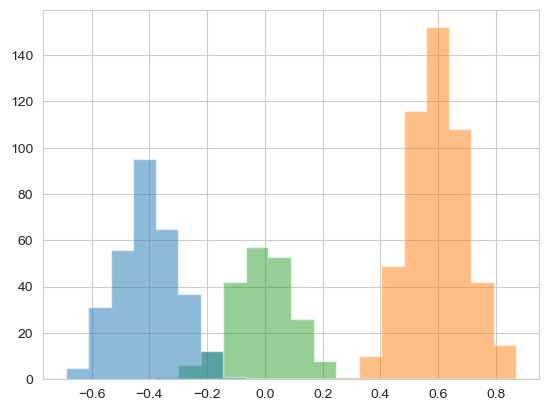

In [31]:
for _ in range(20): gibbs_step(state)
plot_clusters(state)

Nonparametric Mixture Models!

Nonparametric Mixture Models!
It turns out, the collapsed Gibbs sampler for mixture models is almost identical in the context of a nonparametric model. This model uses a Dirichlet process prior instead of a Dirichlet distribution prior. It doesn't require us to specify how many clusters we are looking for in our data.

The cluster assignment score changes slightly. It is proportional to $N_k^{-i}$ for each known cluster. We assign a datapoint to a new cluster with probability proportional to $\alpha$ (which is now the DP dispersion parameter).

In [51]:
def log_cluster_assign_score_dp(cluster_id, state):
    """Log-likelihood that a new point generated will
    be assigned to cluster_id given the current state.
    """
    if cluster_id == "new":
        return np.log(state["alpha_"])
    else:
        return np.log(state['suffstats'][cluster_id].N)

In [59]:
def log_predictive_likelihood_dp(data_id, cluster_id, state):
    """Predictive likelihood of the data at data_id is generated
    by cluster_id given the currenbt state.

    From Section 2.4 of
    http://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
    """
    if cluster_id == "new":
        ss = SuffStat(0, 0)
    else:
        ss = state['suffstats'][cluster_id]

    hp_mean = state['hyperparameters_']['mean']
    hp_var = state['hyperparameters_']['variance']
    param_var = state['cluster_variance_']
    x = state['data_'][data_id]
    return _log_predictive_likelihood(ss, hp_mean, hp_var, param_var, x)

In [60]:
def cluster_assignment_distribution_dp(data_id, state):
    """Compute the marginal distribution of cluster assignment
    for each cluster.
    """
    scores = {}
    cluster_ids = (state['cluster_ids_']) + ['new']
    for cid in cluster_ids:
        scores[cid] = log_predictive_likelihood_dp(data_id, cid, state)
        scores[cid] += log_cluster_assign_score_dp(cid, state)

    for key in scores:
        scores[key] = np.exp(scores[key])
    normalization = 1.0/sum(scores.values())
    for key in scores:
        scores[key] = scores[key] * normalization
    return scores

In [73]:
def create_cluster(state):
    state["num_clusters_"] += 1
    cluster_id = max((state['cluster_ids_'])) + 1
    state['suffstats'][cluster_id]= (SuffStat(0, 0))
    state['cluster_ids_'].append(cluster_id)
    return cluster_id

def destroy_cluster(state, cluster_id):
    state["num_clusters_"] = 1
    del state['suffstats'][cluster_id]
    state['cluster_ids_'].remove(cluster_id)

def prune_clusters(state):
    for cid in state['cluster_ids_']:
        if state['suffstats'][cid].N == 0:
            destroy_cluster(state, cid)

In [74]:
def sample_assignment(data_id, state):
    """Sample new assignment from marginal distribution.
    If cluster is "`new`", create a new cluster.
    """
    scores = cluster_assignment_distribution_dp(data_id, state).items()
    labels, scores = zip(*scores)
    cid = random.choice(labels, p=scores)
    if cid == "new":
        return create_cluster(state)
    else:
        return int(cid)

def gibbs_step_dp(state):
    """Collapsed Gibbs sampler for Dirichlet Process Mixture Model
    """
    pairs = zip(state['data_'], state['assignment'])
    for data_id, (datapoint, cid) in enumerate(pairs):
        state['suffstats'][cid] = remove_datapoint_from_suffstats(datapoint, state['suffstats'][cid])
        prune_clusters(state)
        cid = sample_assignment(data_id, state)
        state['assignment'][data_id] = cid
        state['suffstats'][cid] = add_datapoint_to_suffstats(state['data_'][data_id], state['suffstats'][cid])

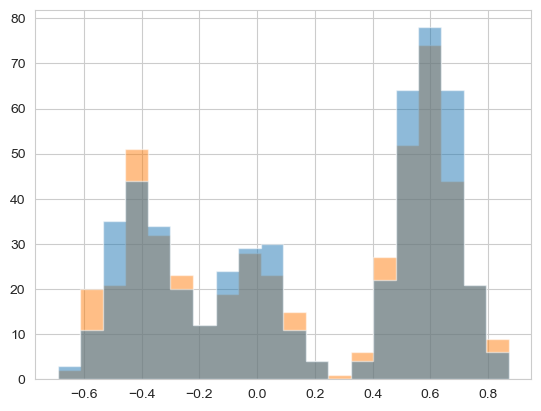

In [75]:
state = initial_state(num_clusters=2, alpha=0.1)
plot_clusters(state)

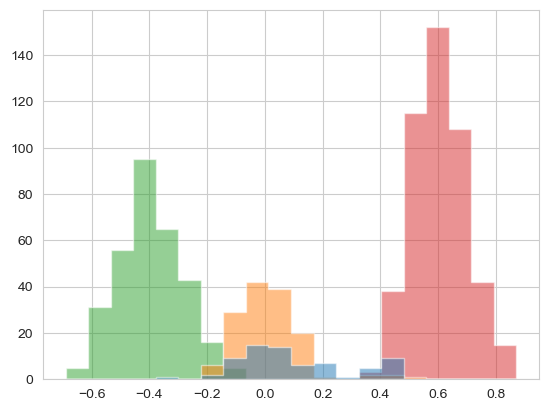

In [76]:
gibbs_step_dp(state)
plot_clusters(state)

/var/folders/8g/9gktnhys29123gd2vy8kl6q40000gn/T/ipykernel_2794/3251378706.py:34: RuntimeWarning: divide by zero encountered in double_scalars
  return SuffStat((ss.theta*(ss.N)-x*1.0)/(ss.N-1), ss.N-1)


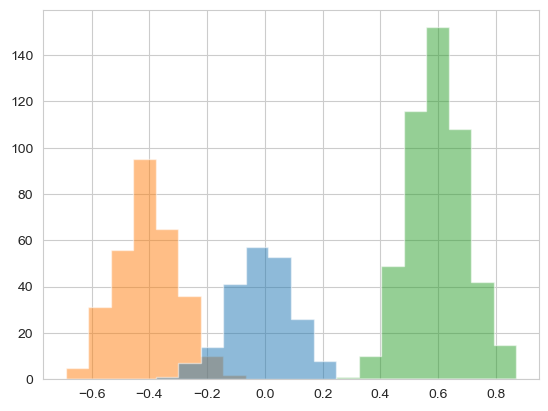

In [77]:
for _ in range(10): gibbs_step_dp(state)
plot_clusters(state)

In [83]:
ss = state['suffstats']
alpha = [ss[cid].N + state['alpha_'] / state['num_clusters_']
         for cid in state['cluster_ids_']]
stats.dirichlet(alpha).rvs(size=1).flatten()

array([0.22186838, 0.3180247 , 0.46010693])

In [84]:
for cluster_id in state['cluster_ids_']:
    cluster_var = state['cluster_variance_']
    hp_mean = state['hyperparameters_']['mean']
    hp_var = state['hyperparameters_']['variance']
    ss = state['suffstats'][cluster_id]

    numerator = hp_mean / hp_var + ss.theta * ss.N / cluster_var
    denominator = (1.0 / hp_var + ss.N / cluster_var)
    posterior_mu = numerator / denominator
    posterior_var = 1.0 / denominator

    mean = stats.norm(posterior_mu, np.sqrt(posterior_var)).rvs()
    print("cluster_id:", cluster_id, "mean", mean)

cluster_id: 1 mean -0.01742199288758225
cluster_id: 2 mean -0.40009668115852975
cluster_id: 3 mean 0.595568007283275
